In this notebook, we are going to compare the TME method against the Euler--Maruyama method for sampling a stochastic Lorenz model. In particular, we want to show their discretisation errors and computational time.

The test model is given as follows. 

$$
\begin{aligned}
    d X_1(t) &= \sigma(X_2(t) - X_1(t)) dt + \sigma_x dW(t), \\
    d X_2(t) &= X_1(t) \, (\rho - X_3(t)) - X_2(t) dt + \sigma_y dW(t), \\
    d X_3(t) &= X_1(t)\,X_2(t) - \beta\,X_3(t) dt + \sigma_z dW(t),
\end{aligned}
$$

The model and its parameters are detailed in https://arxiv.org/pdf/2001.01328.pdf.

First, make sure you have `tme` installed ^^

In [1]:
import tme.base_jax as tme
import jax.numpy as jnp
import jax
from jax import jit, lax
from functools import partial
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

Let us write down the SDE model as well as the discretisation method.

We are going to use a Gaussian increment type of discretisaton method:

$$
X(t_k) \approx \mathbb{E}[X(t_k) \mid X(t_{k-1})] + \xi_k,
$$

where $\xi_k \sim N(0, \mathrm{Cov}[X(t_k) \mid X(t_{k-1})])$. The Euler--Maruyama (EM) and TME methods can be seen as different means to give the conditional mean and covariance above.

The function `disc_normal()` below does this discretisation, where you need to specify how to approximate the mean and covariance in the argument `m_and_cov`. You can feed this argument by `tme_m_cov` or `em_m_cov` that corresponding to TME and EM, respectively.

In [2]:
sigma = 10.
rho = 28.
beta = 8 / 3

def drift(u):
    return jnp.array([sigma * (u[1] - u[0]), 
                     u[0] * (rho - u[2]) - u[1], 
                     u[0] * u[1] - beta * u[2]])

bb = 0.15 * jnp.eye(3)

def dispersion(_):
    return bb

def tme_m_cov(u, dt):
    return tme.mean_and_cov(x=u, dt=dt, drift=drift, dispersion=dispersion, order=3)

def em_m_cov(u, dt):
    return u + drift(u) * dt, dispersion(u) @ dispersion(u).T * dt

@partial(jit, static_argnums=(0,))
def disc_normal(m_and_cov, x0, dts, dws):    
    def scan_body(carry, elem):
        x = carry
        dt, dw = elem

        m, cov = m_and_cov(x, dt)
        x = m + jnp.linalg.cholesky(cov) @ dw
        return x, x

    _, sample = lax.scan(scan_body, x0, (dts, dws))
    return sample

Draw an initial value

In [3]:
key = jax.random.PRNGKey(666)

# Init cond
m0 = jnp.zeros((3, ))
P0 = jnp.eye(3)
key, _ = jax.random.split(key)
x0 = jax.random.multivariate_normal(key=key, mean=m0, cov=P0)

Now we compare the discretisation errors of TME and EM. In order to do so, we need to have these two methods under a same Wiener process realisation. 

Also, we will use EM with very very small dt (here is dt=0.0001) as a reference method serving as a "ground truth solution".

In [4]:
# Very small instances
num_time_steps = 100000
dt = 1e-5
T = jnp.linspace(dt, num_time_steps * dt, num_time_steps)
dts = jnp.diff(T)
key, _ = jax.random.split(key)
dws = jax.random.normal(key, shape=(dts.size, x0.shape[0]))

true_sample = disc_normal(em_m_cov, x0, dts, dws)

Okay, now we make samples from TME and EM with large dt (here is 0.01) so we can compare them how good they are.

In [5]:
# Now make samples from EM and TME with large dt
factor = 1000
T_small = T[::factor]
dts_small = dts[::factor] * factor
dws_small = dws[::factor]
sample_tme = disc_normal(tme_m_cov, x0, dts_small, dws_small)
sample_em = disc_normal(em_m_cov, x0, dts_small, dws_small)

Let us compute the cummaltive absolute errors of TME and EM samples w.r.t. the ground true sample.

In [6]:
def abs_err(x1, x2):
    return jnp.sum(jnp.abs(x1 - x2), (0, 1))

abs_err_tme = abs_err(true_sample[::factor], sample_tme)
abs_err_em = abs_err(true_sample[::factor], sample_em)
print(f'Total abs errors of TME: {abs_err_tme}')
print(f'Total abs errors of EM: {abs_err_em}')

Total abs errors of TME: 218.69788314813277
Total abs errors of EM: 1251.2785396418026


Looks like TME is significantly better than EM. You can try different dt and TME order by yourself.

Let's plot the samples. It looks like TME can perfectly follow the ground truth, while EM diverges a lot!

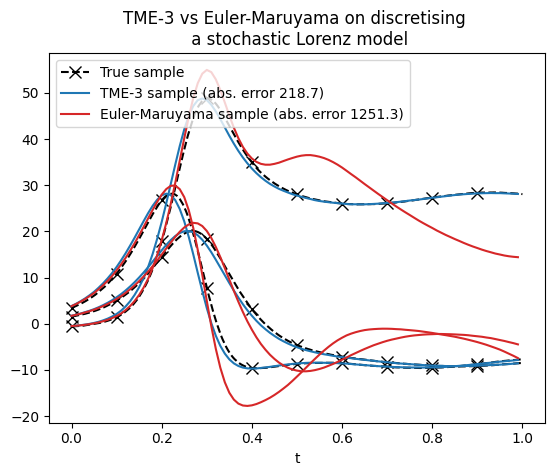

In [7]:
plt.plot(T[1:], true_sample[:, 0], c='black', linestyle='--', 
         marker='x', markevery=num_time_steps // 10, markersize=8, label='True sample')
plt.plot(T[1:], true_sample[:, 1], c='black', 
         marker='x', markevery=num_time_steps // 10, markersize=8, linestyle='--')
plt.plot(T[1:], true_sample[:, 2], c='black', 
         marker='x', markevery=num_time_steps // 10, markersize=8, linestyle='--')
plt.plot(T_small, sample_tme[:, 0], c='tab:blue', label=f'TME-3 sample (abs. error {abs_err_tme:.1f})')
plt.plot(T_small, sample_tme[:, 1], c='tab:blue')
plt.plot(T_small, sample_tme[:, 2], c='tab:blue')
plt.plot(T_small, sample_em[:, 0], c='tab:red', label=f'Euler-Maruyama sample (abs. error {abs_err_em:.1f})')
plt.plot(T_small, sample_em[:, 1], c='tab:red')
plt.plot(T_small, sample_em[:, 2], c='tab:red')
plt.legend(loc='upper left')
_ = plt.title('TME-3 vs Euler-Maruyama on discretising \n a stochastic Lorenz model')
_ = plt.xlabel('t')

Indeed, TME can be more accurate. But how much computational efforts do we lose from using a nuke weapon like TME?

In [8]:
# To trigger compilation, you don't need to load all the data.
_ = disc_normal(tme_m_cov, x0, dts[:2], dws[:2])
_ = disc_normal(em_m_cov, x0, dts[:2], dws[:2])

In [9]:
# Compare time
import time
tic = time.time()
_ = disc_normal(tme_m_cov, x0, dts, dws).block_until_ready()
print(f'TME-3 costs {time.time() - tic:.3f} seconds')

tic = time.time()
_ = disc_normal(em_m_cov, x0, dts, dws).block_until_ready()
print(f'Euler--Maruyama costs {time.time() - tic:.3f} seconds')

TME-3 costs 0.661 seconds
Euler--Maruyama costs 0.051 seconds


In this run, TME-3 is around two times slower than Euler--Maruyama, but this is a worthwhile cost.

Note that the running time really depends on your platform, viz., CPU/GPU. I tried i7-12700K and Geforce 3050, and I found that using the CPU only took ~1e-3 seconds which is much faster than the results above that obtained from using the GPU.

We can also do a 3D plot

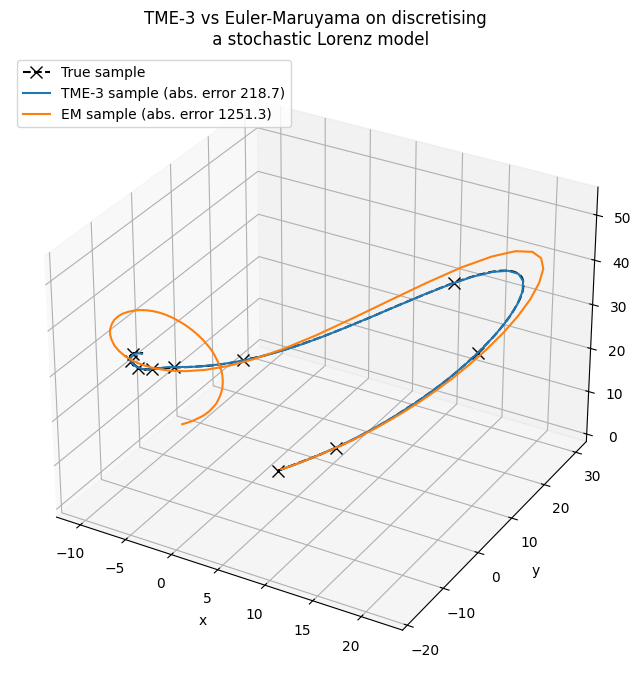

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.plot3D(true_sample[:, 0], true_sample[:, 1], true_sample[:, 2], 
          c='black', linestyle='--', 
          marker='x', markevery=num_time_steps // 10, markersize=8, label='True sample')
ax.plot3D(sample_tme[:, 0], sample_tme[:, 1], sample_tme[:, 2], 
          c='tab:blue', label=f'TME-3 sample (abs. error {abs_err_tme:.1f})')
ax.plot3D(sample_em[:, 0], sample_em[:, 1], sample_em[:, 2], 
          c='tab:orange', label=f'EM sample (abs. error {abs_err_em:.1f})')
ax.legend(loc='upper left')
_ = ax.set_title('TME-3 vs Euler-Maruyama on discretising \n a stochastic Lorenz model')
_ = ax.set_xlabel('x')
_ = ax.set_ylabel('y')
_ = ax.set_zlabel('z')

Exercise: 

Approximate $\mathbb{E}[\phi(X(t)) \mid X(0)]$ by using the `tme.expectation()` function, where $\phi$ is given as a neural network.